# Sentiment analysis on LLY event

Sentiment analysis on the Eli Lilly free insulin event on 11 November 2022, with a dataset from Mastodon. Using BERT trained with the IMDB training set as sentiment analysis model outputting continuous sentiment scores.

Written by Luc Bijl.

Loading the Mastodon dataset.

In [42]:
import pickle

with open('../datasets/mastodon-lly.pkl','rb') as file:
    mastodon_dataframes = pickle.load(file)

We define the date of the event.

In [65]:
date_of_event = '2022-11-10 18:00'

## Sentiment analysis on Lilly

Creating the dataset with toots related to the topics 'Lilly', 'Eli Lilly', 'Eli Lilly and company' and 'LLY'.

In [43]:
import pandas as pd

df_lilly = pd.DataFrame(columns=['Date','ID','Content'])
lilly_topics = ['Lilly', 'Eli Lilly', 'Eli Lilly and company', 'LLY']

for topic in lilly_topics:
    df_lilly = pd.concat([df_lilly,mastodon_dataframes[topic]])

df_lilly.drop_duplicates(subset='ID',keep='first',inplace=True)
df_lilly = df_lilly.set_index('Date')

df_lilly.head(5)

,ID,Content
Date,,
2022-12-08 14:42:58,109478581359363509,"<p>ICYMI yesterday, our new <a href=""https://n..."
2022-12-05 17:58:35,109462365059484871,"<p><span class=""h-card""><a href=""https://roman..."
2022-12-01 20:33:41,109440324430339788,<p>Sophia has nursery toys Charlie and Lilly f...
2022-11-30 18:53:33,109434268151114981,<p>Eli Lilly CEO says insulin tweet flap “prob...
2022-11-28 03:01:05,109419198231109803,<p>Tickets acquired to see The Mountain Goats ...


In [127]:
len(df_lilly)

104

Analyzing the content.

In [44]:
df_lilly['Content'][0]

'<p>ICYMI yesterday, our new <a href="https://newsie.social/tags/cardiovascular" class="mention hashtag" rel="nofollow noopener noreferrer" target="_blank">#<span>cardiovascular</span></a> reporter Elaine Chen reporting on the intersection of <a href="https://newsie.social/tags/obesity" class="mention hashtag" rel="nofollow noopener noreferrer" target="_blank">#<span>obesity</span></a> and <a href="https://newsie.social/tags/diabetes" class="mention hashtag" rel="nofollow noopener noreferrer" target="_blank">#<span>diabetes</span></a>: </p><p>the effects of constricting a drug for one condition that\'s prescribed off-label for another</p><p><a href="https://www.statnews.com/2022/12/07/eli-lilly-tightens-access-tirzepatide-mounjaro-diabetes-obesity/" rel="nofollow noopener noreferrer" target="_blank"><span class="invisible">https://www.</span><span class="ellipsis">statnews.com/2022/12/07/eli-li</span><span class="invisible">lly-tightens-access-tirzepatide-mounjaro-diabetes-obesity/</sp

Creating a function that cleans the content.

In [45]:
from bs4 import BeautifulSoup
import re

def clean_text(text):

    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[#@]', '', text)
    return text

df_lilly['Text'] = df_lilly['Content'].apply(clean_text)

df_lilly['Text'][0]

"ICYMI yesterday, our new cardiovascular reporter Elaine Chen reporting on the intersection of obesity and diabetes: the effects of constricting a drug for one condition that's prescribed off-label for another"

Converting the cleaned text to the language BERT can interpret.

In [46]:
import torch
from transformers import DistilBertTokenizerFast
from torch.utils.data import DataLoader
from transformers import DistilBertForSequenceClassification

model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

lilly_encodings = tokenizer(df_lilly['Text'].tolist(), truncation=True, padding=True, return_tensors='pt')

lilly = torch.utils.data.TensorDataset(lilly_encodings['input_ids'], lilly_encodings['attention_mask'])
lilly_dataloader = DataLoader(lilly, batch_size=16, shuffle=False)

Loading BERT that is trained on the normalized IMDB dataset from Stanford.

In [47]:
bert_model = torch.load('bert-imdb.pth')

Using BERT to perform sentiment analysis on the dataset.

In [48]:
bert_model.eval()
list_predicted_scores = []

with torch.no_grad():
    for batch in lilly_dataloader:
        input_ids, attention_mask = batch
        output = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        predicted_scores = output.logits.view(-1)

        list_predicted_scores.extend(predicted_scores.tolist())

df_lilly['BERT sentiment score'] = list_predicted_scores

df_lilly.head(5)

,ID,Content,Text,BERT sentiment score
Date,,,,
2022-12-08 14:42:58,109478581359363509,"<p>ICYMI yesterday, our new <a href=""https://n...","ICYMI yesterday, our new cardiovascular report...",0.339886
2022-12-05 17:58:35,109462365059484871,"<p><span class=""h-card""><a href=""https://roman...",skimgoth and water lillies?,0.025848
2022-12-01 20:33:41,109440324430339788,<p>Sophia has nursery toys Charlie and Lilly f...,Sophia has nursery toys Charlie and Lilly for ...,0.354358
2022-11-30 18:53:33,109434268151114981,<p>Eli Lilly CEO says insulin tweet flap “prob...,Eli Lilly CEO says insulin tweet flap “probabl...,-0.059616
2022-11-28 03:01:05,109419198231109803,<p>Tickets acquired to see The Mountain Goats ...,Tickets acquired to see The Mountain Goats and...,0.588035


Saving the dataset.

In [156]:
import pickle

with open('../datasets/bert-scored/lilly.pkl', 'wb') as file:
    pickle.dump(df_lilly, file)

### Analyzing the Lilly dataset.

First we will compute the distribution of the dates. This implies to how much toots there have been posted per time interval.

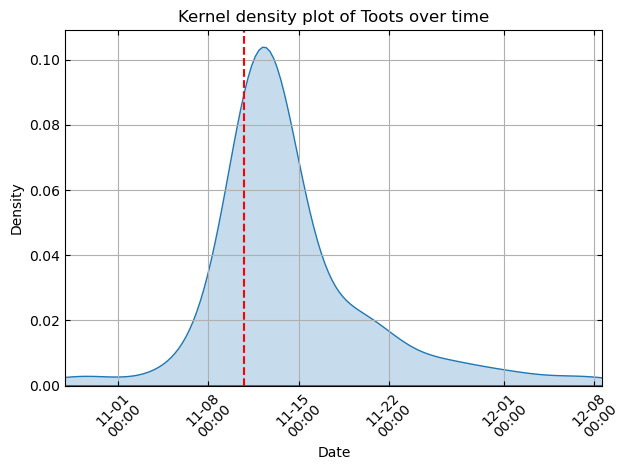

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

sns.kdeplot(data=df_lilly.index, shade=True)

plt.tick_params(axis='both', direction='in',top=True, right=True)
plt.xlim(df_lilly.index.min(),df_lilly.index.max())

plt.xlabel('Date')
plt.title('Kernel density plot of Toots over time')

date_format = DateFormatter("%m-%d\n%H:%M")
plt.gca().xaxis.set_major_formatter(date_format)
plt.xticks(rotation=45)
plt.axvline(pd.to_datetime(date_of_event), color='red', linestyle='--')
plt.grid(True)

plt.tight_layout()
plt.show()

Secondly we will compute the summary statistics.

In [50]:
df_lilly_summary = pd.DataFrame({'min': df_lilly[['BERT sentiment score']].min(numeric_only=True),
                                   'mean': df_lilly[['BERT sentiment score']].mean(numeric_only=True),
                                   'median': df_lilly[['BERT sentiment score']].median(numeric_only=True),
                                   'max': df_lilly[['BERT sentiment score']].max(numeric_only=True)}).T

df_lilly_summary

,BERT sentiment score
min,-0.701116
mean,-0.034357
median,-0.059021
max,0.588035


Thirdly we will compute the distribution of the scores.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


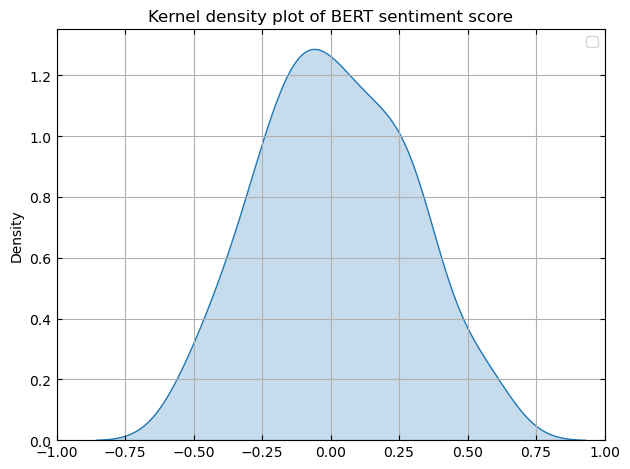

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt

df_lilly_resampled = df_lilly[['BERT sentiment score']].resample('1H').mean().dropna()

sns.kdeplot(data=df_lilly_resampled, shade=True)

plt.tick_params(axis='both', direction='in',top=True, right=True)
plt.xlim(-1,1)
plt.title('Kernel density plot of BERT sentiment score')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Lastly we will plot the sentiment scores against the date and we will compute the filtered mean.

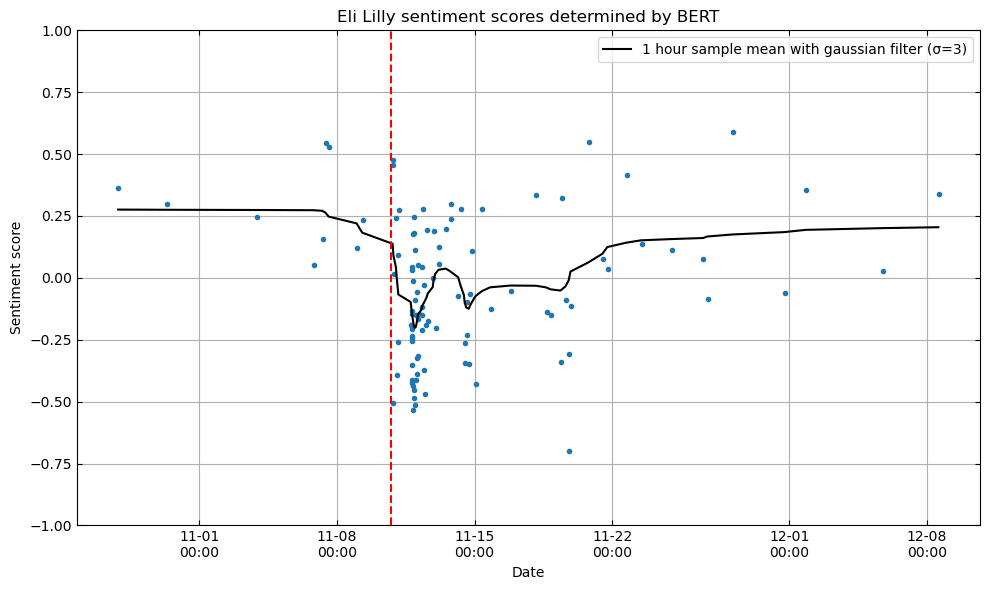

In [133]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

sigma = 3
smoothed_scores = gaussian_filter1d(df_lilly_resampled['BERT sentiment score'], sigma=sigma)

plt.figure(figsize=(10,6))
plt.plot(df_lilly.index, df_lilly['BERT sentiment score'], marker='.', linestyle=' ')
plt.plot(df_lilly_resampled.index, smoothed_scores, color='black', label=f'1 hour sample mean with gaussian filter (σ={sigma})')
plt.ylim(-1,1)

plt.title('Eli Lilly sentiment scores determined by BERT')
plt.xlabel('Date')
plt.ylabel('Sentiment score')
plt.grid(True)

plt.tick_params(axis='both', direction='in',top=True, right=True)
#plt.xlim(df_lilly.index.min(),df_lilly.index.max())
plt.axvline(pd.to_datetime(date_of_event), color='red', linestyle='--')
plt.legend()

date_format = DateFormatter("%m-%d\n%H:%M")
plt.gca().xaxis.set_major_formatter(date_format)

plt.tight_layout()
plt.show()

Zooming in on the event with a period of 2 days before the event and 7 days after the event.

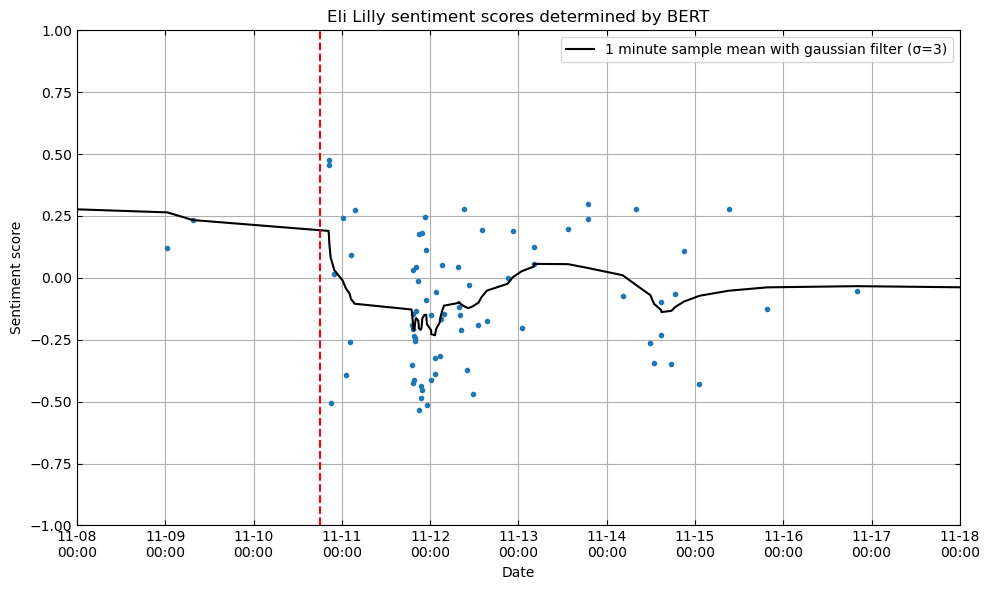

In [152]:
df_lilly_resampled = df_lilly[['BERT sentiment score']].resample('60S').mean().dropna()

sigma = 3
smoothed_scores = gaussian_filter1d(df_lilly_resampled['BERT sentiment score'], sigma=sigma)

date_start = '2022-11-8'
date_end =  '2022-11-18'

plt.figure(figsize=(10,6))
plt.plot(df_lilly.index, df_lilly['BERT sentiment score'], marker='.', linestyle=' ')
plt.plot(df_lilly_resampled.index, smoothed_scores, color='black', label=f'1 minute sample mean with gaussian filter (σ={sigma})')

plt.ylim(-1,1)

plt.title('Eli Lilly sentiment scores determined by BERT')
plt.xlabel('Date')
plt.ylabel('Sentiment score')
plt.grid(True)

plt.tick_params(axis='both', direction='in',top=True, right=True)
plt.xlim(pd.to_datetime(date_start),pd.to_datetime(date_end))
plt.axvline(pd.to_datetime(date_of_event), color='red', linestyle='--')
plt.legend()

date_format = DateFormatter("%m-%d\n%H:%M")
plt.gca().xaxis.set_major_formatter(date_format)

plt.tight_layout()
plt.show()

## Sentiment analysis on Insulin

Creating the dataset with toots related to the topic 'Insulin'.

In [53]:
df_insulin = mastodon_dataframes['Insulin']
df_insulin = df_insulin.set_index('Date')

df_insulin.head()

,ID,Content
Date,,
2022-12-09 20:09:41,109485528680726575,<p>Henceforth my insulin pump shall be known a...
2022-12-09 14:52:21,109484280827598555,
2022-12-09 10:31:24,109483255136181443,<p>fri/20221209</p>
2022-12-09 06:23:15,109482278888205908,<p>Being an insulin-injecting diabetic means o...
2022-12-08 23:16:32,109480601078091132,<p>I am now part cyborg and have sent my first...


In [128]:
len(df_insulin)

150

Analyzing the content.

In [62]:
df_insulin['Content'][0]

'<p>Henceforth my insulin pump shall be known as H.E.R.B.I.E. <a href="https://social.parentheticalrecluse.com/tags/t1d" class="mention hashtag" rel="nofollow noopener noreferrer" target="_blank">#<span>t1d</span></a></p>'

Cleaning the dataset.

In [61]:
df_insulin['Text'] = df_insulin['Content'].apply(clean_text)

df_insulin['Text'][0]

'Henceforth my insulin pump shall be known as H.E.R.B.I.E. t1d'

Converting the cleaned text to the language BERT can interpret.

In [63]:
import torch
from transformers import DistilBertTokenizerFast
from torch.utils.data import DataLoader
from transformers import DistilBertForSequenceClassification

model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

insulin_encodings = tokenizer(df_insulin['Text'].tolist(), truncation=True, padding=True, return_tensors='pt')

insulin = torch.utils.data.TensorDataset(insulin_encodings['input_ids'], insulin_encodings['attention_mask'])
insulin_dataloader = DataLoader(insulin, batch_size=16, shuffle=False)

Using BERT to perform sentiment analysis on the dataset.

In [64]:
bert_model.eval()
list_predicted_scores = []

with torch.no_grad():
    for batch in insulin_dataloader:
        input_ids, attention_mask = batch
        output = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        predicted_scores = output.logits.view(-1)

        list_predicted_scores.extend(predicted_scores.tolist())

df_insulin['BERT sentiment score'] = list_predicted_scores

df_insulin.head(5)

,ID,Content,Text,BERT sentiment score
Date,,,,
2022-12-09 20:09:41,109485528680726575,<p>Henceforth my insulin pump shall be known a...,Henceforth my insulin pump shall be known as H...,0.184103
2022-12-09 14:52:21,109484280827598555,,,0.014581
2022-12-09 10:31:24,109483255136181443,<p>fri/20221209</p>,fri/20221209,0.160710
2022-12-09 06:23:15,109482278888205908,<p>Being an insulin-injecting diabetic means o...,Being an insulin-injecting diabetic means occa...,-0.223550
2022-12-08 23:16:32,109480601078091132,<p>I am now part cyborg and have sent my first...,I am now part cyborg and have sent my first in...,-0.073293


Saving the dataset.

In [155]:
import pickle

with open('../datasets/bert-scored/insulin.pkl', 'wb') as file:
    pickle.dump(df_insulin, file)

### Analyzing the Insulin dataset

First we will compute the distribution of the dates. This implies to how much toots there have been posted per time interval.

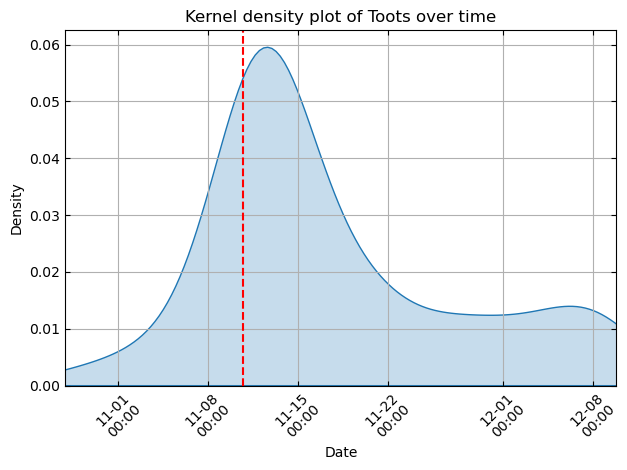

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

sns.kdeplot(data=df_insulin.index, shade=True)

plt.tick_params(axis='both', direction='in',top=True, right=True)
plt.xlim(df_insulin.index.min(),df_insulin.index.max())

plt.xlabel('Date')
plt.title('Kernel density plot of Toots over time')

date_format = DateFormatter("%m-%d\n%H:%M")
plt.gca().xaxis.set_major_formatter(date_format)
plt.xticks(rotation=45)
plt.axvline(pd.to_datetime(date_of_event), color='red', linestyle='--')
plt.grid(True)

plt.tight_layout()
plt.show()

Secondly we will compute the summary statistics.

In [69]:
df_insulin_summary = pd.DataFrame({'min': df_insulin[['BERT sentiment score']].min(numeric_only=True),
                                   'mean': df_insulin[['BERT sentiment score']].mean(numeric_only=True),
                                   'median': df_insulin[['BERT sentiment score']].median(numeric_only=True),
                                   'max': df_insulin[['BERT sentiment score']].max(numeric_only=True)}).T

df_insulin_summary

,BERT sentiment score
min,-0.701116
mean,-0.053602
median,-0.085887
max,0.599067


Thirdly we will compute the distribution of the scores.

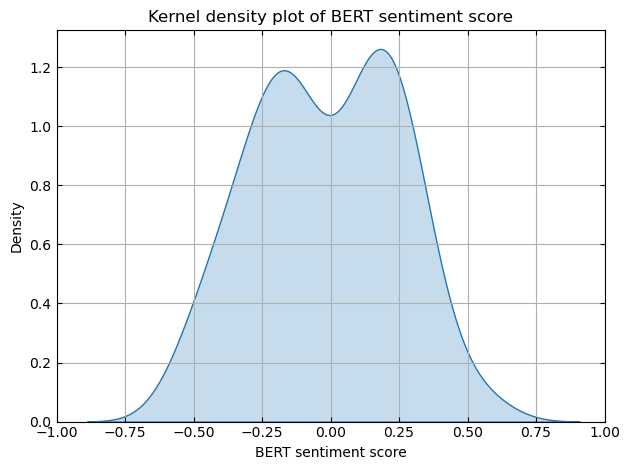

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

df_insulin_resampled = df_insulin[['BERT sentiment score']].resample('1H').mean().dropna()

sns.kdeplot(df_insulin_resampled['BERT sentiment score'], shade=True)

plt.tick_params(axis='both', direction='in',top=True, right=True)
plt.xlim(-1,1)
plt.title('Kernel density plot of BERT sentiment score')
plt.grid(True)

plt.tight_layout()
plt.show()

Lastly we will plot the sentiment scores against the date and we will compute the filtered mean.

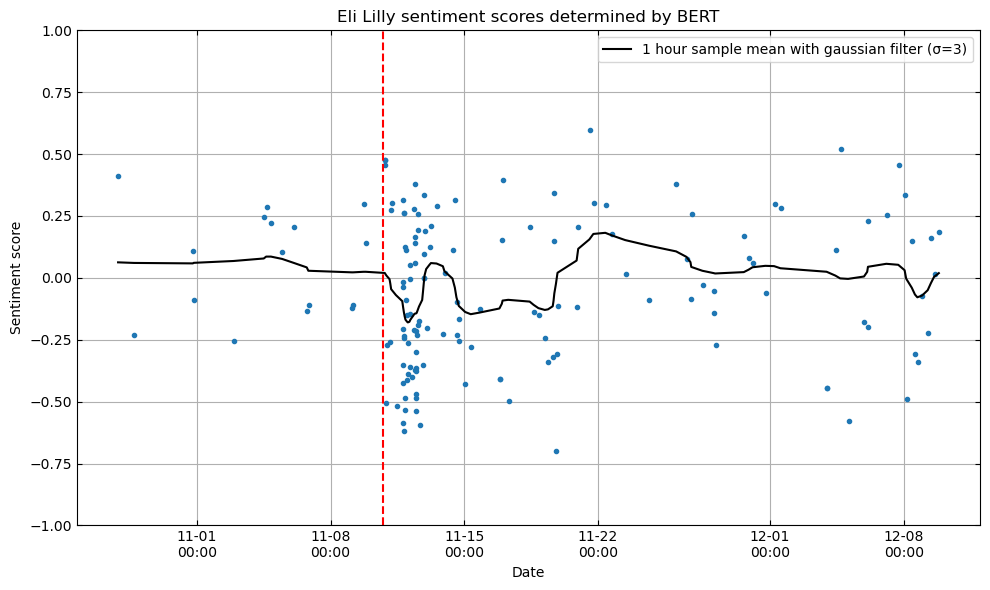

In [132]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

sigma = 3
smoothed_scores = gaussian_filter1d(df_insulin_resampled['BERT sentiment score'], sigma=sigma)

plt.figure(figsize=(10,6))
plt.plot(df_insulin.index, df_insulin['BERT sentiment score'], marker='.', linestyle=' ')
plt.plot(df_insulin_resampled.index, smoothed_scores, color='black', label=f'1 hour sample mean with gaussian filter (σ={sigma})')
plt.ylim(-1,1)

plt.title('Eli Lilly sentiment scores determined by BERT')
plt.xlabel('Date')
plt.ylabel('Sentiment score')
plt.grid(True)

plt.tick_params(axis='both', direction='in',top=True, right=True)
#plt.xlim(df_lilly.index.min(),df_lilly.index.max())
plt.axvline(pd.to_datetime(date_of_event), color='red', linestyle='--')
plt.legend()

date_format = DateFormatter("%m-%d\n%H:%M")
plt.gca().xaxis.set_major_formatter(date_format)

plt.tight_layout()
plt.show()

## Sentiment analysis on the total dataset

Creating the dataset with toots related to the topics 'Lilly', 'Eli Lilly', 'Eli Lilly and company', 'LLY', 'Insulin', 'Diabetes', 'Diabetic', 'Medicine', 'Medical' and 'Pharmaceutical'.

In [113]:
df_total = pd.DataFrame(columns=['Date','ID','Content'])
topics = [
    'Lilly', 'Eli Lilly', 'Eli Lilly and company', 'LLY',
    'Insulin', 
    'Diabetes', 'Diabetic',
    'Medicine', 'Medical',
    'pharmaceutical'
]

for topic in topics:
    df_total = pd.concat([df_total,mastodon_dataframes[topic]])

df_total.drop_duplicates(subset='ID',keep='first',inplace=True)
df_total = df_total.set_index('Date')

df_total.head(5)

,ID,Content
Date,,
2022-12-08 14:42:58,109478581359363509,"<p>ICYMI yesterday, our new <a href=""https://n..."
2022-12-05 17:58:35,109462365059484871,"<p><span class=""h-card""><a href=""https://roman..."
2022-12-01 20:33:41,109440324430339788,<p>Sophia has nursery toys Charlie and Lilly f...
2022-11-30 18:53:33,109434268151114981,<p>Eli Lilly CEO says insulin tweet flap “prob...
2022-11-28 03:01:05,109419198231109803,<p>Tickets acquired to see The Mountain Goats ...


In [129]:
len(df_total)

1545

Analyzing the content.

In [114]:
df_total['Content'][0]

'<p>ICYMI yesterday, our new <a href="https://newsie.social/tags/cardiovascular" class="mention hashtag" rel="nofollow noopener noreferrer" target="_blank">#<span>cardiovascular</span></a> reporter Elaine Chen reporting on the intersection of <a href="https://newsie.social/tags/obesity" class="mention hashtag" rel="nofollow noopener noreferrer" target="_blank">#<span>obesity</span></a> and <a href="https://newsie.social/tags/diabetes" class="mention hashtag" rel="nofollow noopener noreferrer" target="_blank">#<span>diabetes</span></a>: </p><p>the effects of constricting a drug for one condition that\'s prescribed off-label for another</p><p><a href="https://www.statnews.com/2022/12/07/eli-lilly-tightens-access-tirzepatide-mounjaro-diabetes-obesity/" rel="nofollow noopener noreferrer" target="_blank"><span class="invisible">https://www.</span><span class="ellipsis">statnews.com/2022/12/07/eli-li</span><span class="invisible">lly-tightens-access-tirzepatide-mounjaro-diabetes-obesity/</sp

Cleaning the dataset.

In [115]:
df_total['Text'] = df_total['Content'].apply(clean_text)

df_total['Text'][0]

"ICYMI yesterday, our new cardiovascular reporter Elaine Chen reporting on the intersection of obesity and diabetes: the effects of constricting a drug for one condition that's prescribed off-label for another"

Converting the cleaned text to the language BERT can interpret.

In [116]:
import torch
from transformers import DistilBertTokenizerFast
from torch.utils.data import DataLoader
from transformers import DistilBertForSequenceClassification

model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

total_encodings = tokenizer(df_total['Text'].tolist(), truncation=True, padding=True, return_tensors='pt')

total = torch.utils.data.TensorDataset(total_encodings['input_ids'], total_encodings['attention_mask'])
total_dataloader = DataLoader(total, batch_size=16, shuffle=False)

Using BERT to perform sentiment analysis on the dataset.

In [117]:
bert_model.eval()
list_predicted_scores = []

with torch.no_grad():
    for batch in total_dataloader:
        input_ids, attention_mask = batch
        output = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        predicted_scores = output.logits.view(-1)

        list_predicted_scores.extend(predicted_scores.tolist())

df_total['BERT sentiment score'] = list_predicted_scores

df_total.head(5)

,ID,Content,Text,BERT sentiment score
Date,,,,
2022-12-08 14:42:58,109478581359363509,"<p>ICYMI yesterday, our new <a href=""https://n...","ICYMI yesterday, our new cardiovascular report...",0.339886
2022-12-05 17:58:35,109462365059484871,"<p><span class=""h-card""><a href=""https://roman...",skimgoth and water lillies?,0.025848
2022-12-01 20:33:41,109440324430339788,<p>Sophia has nursery toys Charlie and Lilly f...,Sophia has nursery toys Charlie and Lilly for ...,0.354358
2022-11-30 18:53:33,109434268151114981,<p>Eli Lilly CEO says insulin tweet flap “prob...,Eli Lilly CEO says insulin tweet flap “probabl...,-0.059616
2022-11-28 03:01:05,109419198231109803,<p>Tickets acquired to see The Mountain Goats ...,Tickets acquired to see The Mountain Goats and...,0.588035


Saving the dataset.

In [154]:
import pickle

with open('../datasets/bert-scored/total.pkl', 'wb') as file:
    pickle.dump(df_total, file)

### Analyzing the total dataset

First we will compute the distribution of the dates. This implies to how much toots there have been posted per time interval.

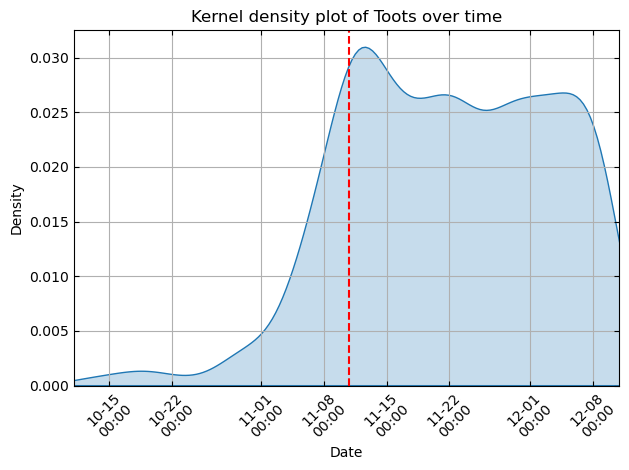

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

sns.kdeplot(data=df_total.index, shade=True)

plt.tick_params(axis='both', direction='in',top=True, right=True)
plt.xlim(df_total.index.min(),df_total.index.max())

plt.xlabel('Date')
plt.title('Kernel density plot of Toots over time')

date_format = DateFormatter("%m-%d\n%H:%M")
plt.gca().xaxis.set_major_formatter(date_format)
plt.xticks(rotation=45)
plt.axvline(pd.to_datetime(date_of_event), color='red', linestyle='--')
plt.grid(True)

plt.tight_layout()
plt.show()

Secondly we will compute the summary statistics.

In [119]:
df_total_summary = pd.DataFrame({'min': df_total[['BERT sentiment score']].min(numeric_only=True),
                                   'mean': df_total[['BERT sentiment score']].mean(numeric_only=True),
                                   'median': df_total[['BERT sentiment score']].median(numeric_only=True),
                                   'max': df_total[['BERT sentiment score']].max(numeric_only=True)}).T

df_total_summary

,BERT sentiment score
min,-0.750644
mean,0.006050
median,0.008731
max,0.798334


Thirdly we will compute the distribution of the scores.

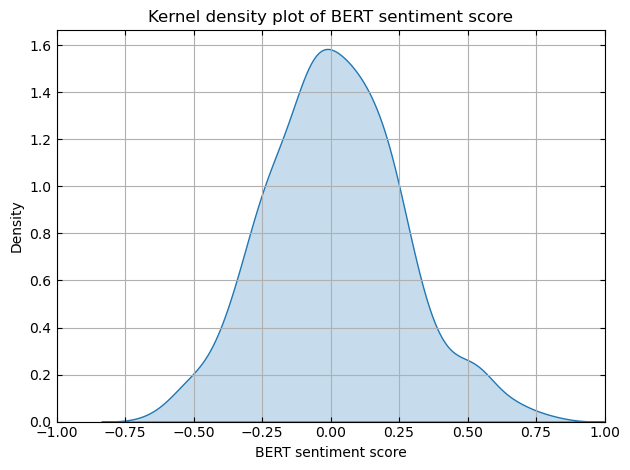

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt

df_total_resampled = df_total[['BERT sentiment score']].resample('1H').mean().dropna()

sns.kdeplot(df_total_resampled['BERT sentiment score'], shade=True)

plt.tick_params(axis='both', direction='in',top=True, right=True)
plt.xlim(-1,1)
plt.title('Kernel density plot of BERT sentiment score')
plt.grid(True)

plt.tight_layout()
plt.show()

Lastly we will plot the sentiment scores against the date and we will compute the filtered mean.

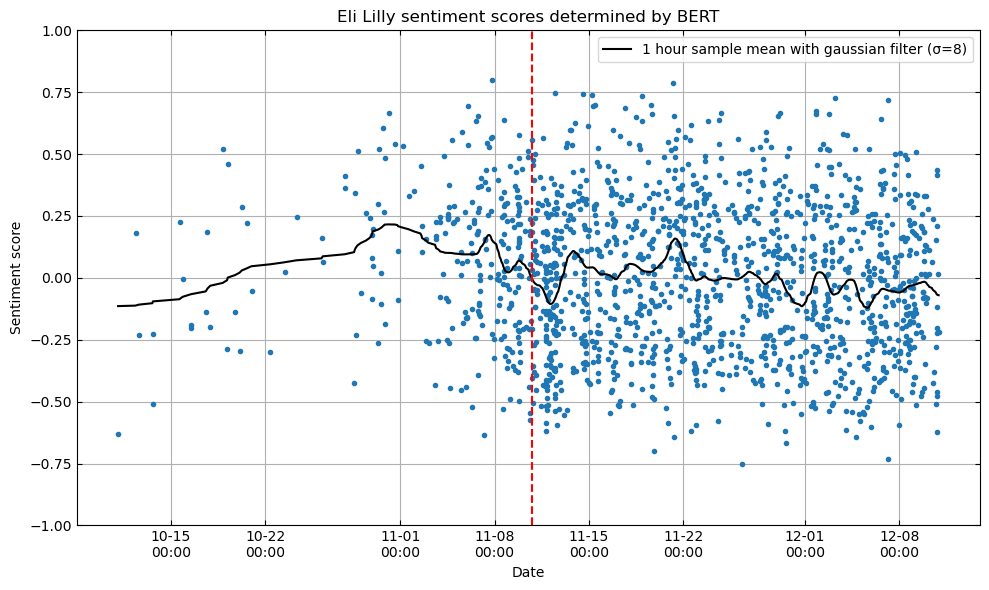

In [131]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

sigma = 8
smoothed_scores = gaussian_filter1d(df_total_resampled['BERT sentiment score'], sigma=sigma)

plt.figure(figsize=(10,6))
plt.plot(df_total.index, df_total['BERT sentiment score'], marker='.', linestyle=' ')
plt.plot(df_total_resampled.index, smoothed_scores, color='black', label=f'1 hour sample mean with gaussian filter (σ={sigma})')
plt.ylim(-1,1)

plt.title('Eli Lilly sentiment scores determined by BERT')
plt.xlabel('Date')
plt.ylabel('Sentiment score')
plt.grid(True)

plt.tick_params(axis='both', direction='in',top=True, right=True)
#plt.xlim(df_lilly.index.min(),df_lilly.index.max())
plt.axvline(pd.to_datetime(date_of_event), color='red', linestyle='--')
plt.legend()

date_format = DateFormatter("%m-%d\n%H:%M")
plt.gca().xaxis.set_major_formatter(date_format)

plt.tight_layout()
plt.show()